# GUÍA 7.2: PREDICCIÓN DE DESERCIÓN DE ALUMNOS Y POSIBLES CONTRAFACTUALES

Alumno: Ricardo Amiel Acuña Villogas

## **Carguemos el modelo**

In [8]:
import pickle

loaded_model = pickle.load(open('best_desertion_random_forest_model.pkl', 'rb'))

## **PIPELINE PARA ENTRENAR CON DATOS EXTERNOS**
Una función que haga el preprocesamiento de la data

In [9]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Función para agrupar y transformar el DataFrame
def group_and_transform(df):
    
    # Imputación de valores nulos: numéricos con media y categóricos con moda
    for column in df.columns:
        if df[column].dtype == 'object':  # Para variables categóricas
            df[column].fillna(df[column].mode()[0], inplace=True)
        else:  # Para variables numéricas
            df[column].fillna(df[column].mean(), inplace=True)
    
    df_grouped = df.groupby('COD_ALUMNO').agg({
        'SEXO': 'first',  # Sexo no cambia, tomamos el primero
        'EDAD': 'last',  # Fecha de nacimiento tampoco cambia
        'ESTADO': 'last',  # Tomar el último estado
        'SEM_CURSADOS': 'max',  # Semestres cursados totales
        'CANT_RESERVAS': 'sum',  # Total de reservas de cursos
        'NOTA': 'mean',  # Promedio de nota
        'APROBO': lambda x: (x == 'S').mean(),  # Proporción de cursos aprobados
        'CREDITOS': 'sum',  # Créditos totales cursados
        'HRS_INASISTENCIA': 'sum',  # Horas totales de inasistencia
        'HRS_CURSO': 'sum',  # Horas totales de curso
        'PRCTJE_INASISTENCIA': 'mean',  # Porcentaje promedio de inasistencia
        'PONDERADO': 'mean',  # Promedio ponderado final
        'BECA_VIGENTE': 'max',  # Si tuvo alguna beca
        'IDH': 'first',  # IDH del lugar de procedencia
        'POR_POBREZA': 'first',  # Porcentaje de pobreza del lugar de procedencia
        'POR_POBREZA_EXTREMA': 'first',  # Porcentaje de pobreza extrema del lugar de procedencia
        'TIPO_CURSO': lambda x: (x == 2).mean() # Proporción de cursos obligatorios
    }).reset_index()

    df_grouped = df_grouped.rename(columns={'TIPO_CURSO': 'PROP_OBLIGATORIOS'})
    df_grouped['CAMBIO_RENDIMIENTO'] = df.groupby('COD_ALUMNO')['NOTA'].transform(lambda x: x.iloc[-1] - x.iloc[0])

    # Redondear a 2 decimales
    df_grouped['NOTA'] = df_grouped['NOTA'].round(2)
    df_grouped['APROBO'] = df_grouped['APROBO'].round(2)
    df_grouped['PRCTJE_INASISTENCIA'] = df_grouped['PRCTJE_INASISTENCIA'].round(2)
    df_grouped['PONDERADO'] = df_grouped['PONDERADO'].round(2)
    df_grouped['PROP_OBLIGATORIOS'] = df_grouped['PROP_OBLIGATORIOS'].round(2)

    # Convertir a enteros
    df_grouped['COD_ALUMNO'] = df_grouped['COD_ALUMNO'].astype(int)
    df_grouped['SEM_CURSADOS'] = df_grouped['SEM_CURSADOS'].astype(int)
    df_grouped['CANT_RESERVAS'] = df_grouped['CANT_RESERVAS'].astype(int)
    df_grouped['CREDITOS'] = df_grouped['CREDITOS'].astype(int)
    df_grouped['HRS_INASISTENCIA'] = df_grouped['HRS_INASISTENCIA'].astype(int)
    df_grouped['HRS_CURSO'] = df_grouped['HRS_CURSO'].astype(int)
    df_grouped['BECA_VIGENTE'] = df_grouped['BECA_VIGENTE'].astype(int)

    # Crear la nueva columna 'y'
    df_grouped['y'] = df_grouped['ESTADO'].apply(lambda x: 1 if x in ['Egresado', 'Regular'] else 0)

    return df_grouped

# Crear el pipeline
pipeline = Pipeline([
    ('group_and_transform', FunctionTransformer(group_and_transform, validate=False))
])

# Supongamos que df es tu DataFrame original
df = pd.read_csv('Desercion_clean_enriched.csv')

# Aplicar el pipeline
df_transformed = pipeline.fit_transform(df)

# Mostrar el DataFrame transformado
df_transformed.head()

,COD_ALUMNO,SEXO,EDAD,ESTADO,SEM_CURSADOS,CANT_RESERVAS,NOTA,APROBO,CREDITOS,HRS_INASISTENCIA,HRS_CURSO,PRCTJE_INASISTENCIA,PONDERADO,BECA_VIGENTE,IDH,POR_POBREZA,POR_POBREZA_EXTREMA,PROP_OBLIGATORIOS,CAMBIO_RENDIMIENTO,y
0,2041,M,34,Retirado,1,0,10.80,0.57,22,13,432,30.71,9.80,0,0.6739,6.4,0.5,1.0,2.44,0
1,2106,F,36,Retirado,1,0,0.04,0.00,22,317,432,30.71,0.03,0,0.7622,0.7,0.0,1.0,2.44,0
2,2385,M,36,Separado,1,0,2.61,0.00,22,115,432,30.71,2.49,0,0.6591,8.2,0.2,1.0,2.44,0
3,2387,M,34,Separado,1,0,5.19,0.00,22,74,432,30.71,4.87,0,0.7622,0.7,0.0,1.0,2.44,0
4,2392,F,17,Abandono,1,0,12.53,0.57,22,22,432,30.71,12.44,0,0.4906,34.8,21.8,1.0,2.44,0


F1-score con datos externos: 0.9903565166569258


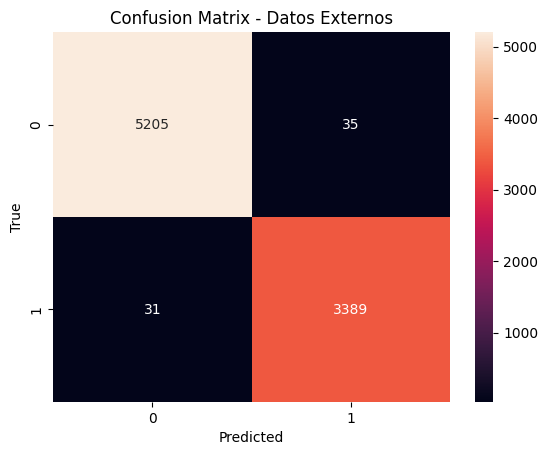

In [10]:
from dice_ml import Dice
import dice_ml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    df = group_and_transform(df)
    label_encoder_sexo = LabelEncoder()
    label_encoder_sexo.fit(df['SEXO'])
    # Realizar las mismas transformaciones que aplicaste a los datos originales
    df['SEXO'] = label_encoder_sexo.transform(df['SEXO'])
    
    # Seleccionar las mismas columnas relevantes
    X = df.drop(columns=['COD_ALUMNO', 'y', 'ESTADO', 'CANT_RESERVAS', 'POR_POBREZA', 'POR_POBREZA_EXTREMA'])
    y = df['y']
    return X, y, df

# Cargar datos externos (simulando un archivo CSV externo)
external_data = pd.read_csv('Desercion_clean_enriched.csv')  # El dataframe en  crudo
X_ext, y_ext, df_transformado = preprocess_data(external_data) # Pipeline para agrupar y luego preprocesar

# Predecir usando el modelo cargado
ypred_ext = loaded_model.predict(X_ext)

# Evaluar el modelo con los datos externos
f1_ext = f1_score(y_ext, ypred_ext)
print(f"F1-score con datos externos: {f1_ext}")

# Generar la matriz de confusión para los datos externos
cm_ext = confusion_matrix(y_ext, ypred_ext)
sns.heatmap(cm_ext, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Datos Externos')
plt.show()

## **PIPELINE PARA TESTEAR CONTRAFACTUALES PARA ALUMNOS NUEVOS**

Creemos un dataframe sintético y evaluemos.

In [11]:

from itertools import count
import pandas as pd
from dice_ml import Dice
import dice_ml
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix 
import json

# Crear un DataFrame con 5 registros para un solo alumno
data = {
    'COD_PERSONA': [10073.0] * 5,
    'COD_ALUMNO': [969696.0] * 5,
    'SEXO': ['M'] * 5,
    'PER_INGRESO': ['2005-01'] * 5,
    'ESTADO_CIVIL': ['S'] * 5,
    'TIPO_COLEGIO': ['Público en Convenio'] * 5,
    'PTJE_INGRESO': [114.8] * 5,
    'CARRERA': ['INGENIERÍA INDUSTRIAL'] * 5,
    'ESTADO': ['Separado'] * 5,
    'SEM_ALUMNO': [2.0] * 5,
    'SEM_CURSADOS': [2.0] * 5,
    'CANT_RESERVAS': [1.0] * 5,
    'PER_MATRICULA': ['2004-02'] * 5,
    'COD_CURSO': [886.0, 887.0, 885.0, 888.0, 890.0],
    'CURSO': ['Metodología del Estudio', 'Matemática Básica', 'Introducción a la Vida Universitaria', 'Álgebra Lineal y Geometría Analítica', 'Química 1'],
    'CREDITOS': [3.0, 3.0, 3.0, 5.0, 3.0],
    'TIPO_CURSO': [2] * 5,
    'COD_PLAN': [49.0] * 5,
    'COD_GRUPO': [3189.0, 3187.0, 3193.0, 3190.0, 3191.0],
    'GRUPO': ['IND-1B'] * 5,
    'NOTA': [7.26, 7.35, 10.2, 8.5, 9.0],
    'APROBO': ['N'] * 3+['S']*2,
    'HRS_INASISTENCIA': [5.0, 0.0, 0.0, 2.0, 3.0],
    'HRS_CURSO': [48.0, 64.0, 48.0, 50.0, 52.0],
    'PRCTJE_INASISTENCIA': [13.0] * 5,
    'PONDERADO': [7.7933] * 5,
    'CRED_GRADUACION': [217.0] * 5,
    'BECA_VIGENTE': [0.0] * 5,
    'NOTA_ENCUESTA_DOC': [0.0] * 5,
    'Departamento_Procedencia': ['AREQUIPA'] * 5,
    'Provincia_Procedencia': ['AREQUIPA'] * 5,
    'Distrito_Procedencia': ['AREQUIPA'] * 5,
    'Departamento_Residencia': ['AREQUIPA'] * 5,
    'Provincia_Residencia': ['AREQUIPA'] * 5,
    'Distrito_Residencia': ['AREQUIPA'] * 5,
    'POBLACION': [10119] * 5,
    'IDH': [0.4906] * 5,
    'POR_POBREZA': [34.8] * 5,
    'POR_POBREZA_EXTREMA': [21.8] * 5,
    'EDAD': [17] * 5
}


#guardar data como json

with open('jsons/alumno.json', 'w') as f:
    json.dump(data, f)

muestra = pd.read_csv('Desercion_clean_enriched.csv')  # Cambia con el path del 
#muestra = muestra.head(7)

# PIPELINE PARA LOS CONTRAFACTUALES
def pipeline_contrafactuales(alumno, dataframe, model):
    # Convertir a dataframe alumno, pues es un json
    alumno = pd.DataFrame(alumno)
    
    # Preprocesar los alumnos
    X_nuevos, y_nuevos, X_transformado = preprocess_data(alumno)
    
    # Preprocesar
    dataframeX, dataframeY, dataframeTransformado = preprocess_data(dataframe)
    
    # unir los dataframes
    dataframeX = pd.concat([dataframeX, X_nuevos]).reset_index(drop=True)
    dataframeY = pd.concat([dataframeY, y_nuevos]).reset_index(drop=True)
    dataframeTransformado = pd.concat([dataframeTransformado, X_transformado]).reset_index(drop=True)

    # Predecir con el modelo cargado
    pred_nuevos = model.predict(X_nuevos).reshape(1, -1)

    # Si la predicción es de deserción (0), generamos contrafactuales
    if pred_nuevos[0] == 0:
        print(f"Generando contrafactuales para evitar deserción del alumno...")

        # Preparar DiCE con los datos del nuevo alumno
        dice_data_nuevo = dice_ml.Data(
            dataframe=dataframeX.join(dataframeY), 
            continuous_features=['APROBO', 'NOTA', 'PRCTJE_INASISTENCIA',
                                              'PONDERADO', 'IDH','PROP_OBLIGATORIOS','CAMBIO_RENDIMIENTO'], outcome_name='y')
        
        dice_model = dice_ml.Model(model=model, backend="sklearn")
        
        alumno_ = dataframeX.iloc[len(dataframeX)-1:len(dataframeX)]

        # Generar los contrafactuales
        dice_nuevo = Dice(dice_data_nuevo, dice_model)
        counterfactuals_nuevo = dice_nuevo.generate_counterfactuals(
            alumno_, 
            total_CFs=10, 
            desired_class=1,
            features_to_vary=['APROBO', 'NOTA', 'PONDERADO','BECA_VIGENTE','CAMBIO_RENDIMIENTO'],
            permitted_range={'APROBO': [alumno_['APROBO'].values[0], int(max(dataframeX['APROBO'].values))-0.3], 
                             'NOTA': [alumno_['NOTA'].values[0]+1.0, int(max(dataframeX['NOTA'].values))-5],
                             'PONDERADO': [alumno_['PONDERADO'].values[0], int(max(dataframeX['PONDERADO'].values))-6.0],
                             'CAMBIO_RENDIMIENTO': [alumno_['CAMBIO_RENDIMIENTO'].values[0], alumno_['CAMBIO_RENDIMIENTO'].values[0]+1.0],
                             }
        )
        
        # Mostrar los contrafactuales generados
        counterfactuals_nuevo.visualize_as_dataframe()
        
        # guardar en json al alumno de entrada alumno_
        
        alumno_.to_json('guia7-2-alumno.json', orient='records')
        
        counterfactuals_nuevo.cf_examples_list[0].final_cfs_df.to_csv('guia7-2-counterfactuals.csv', index=False)
        
        counterfactuals_nuevo.cf_examples_list[0].final_cfs_df.to_json('guia7-2-counterfactuals.json', orient='records')
        
    else:
        print(f"El alumno no fue clasificado como desertor.")

In [12]:
xd = pd.read_json('jsons/alumno3.json')

pipeline_contrafactuales(xd, muestra, loaded_model)

Generando contrafactuales para evitar deserción del alumno...


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Query instance (original outcome : 0)


,SEXO,EDAD,SEM_CURSADOS,NOTA,APROBO,CREDITOS,HRS_INASISTENCIA,HRS_CURSO,PRCTJE_INASISTENCIA,PONDERADO,BECA_VIGENTE,IDH,PROP_OBLIGATORIOS,CAMBIO_RENDIMIENTO,y
0,0,17,4,8.46,0.0,17,100,162,23.0,7.79,0,0.4906,1.0,1.74,0



Diverse Counterfactual set (new outcome: 1)


,SEXO,EDAD,SEM_CURSADOS,NOTA,APROBO,CREDITOS,HRS_INASISTENCIA,HRS_CURSO,PRCTJE_INASISTENCIA,PONDERADO,BECA_VIGENTE,IDH,PROP_OBLIGATORIOS,CAMBIO_RENDIMIENTO,y
0,0,17,4,8.46,0.8,17,100,162,23.0,11.8,0,0.4906,1.0,1.74,1
1,0,17,4,8.46,0.7,17,100,162,23.0,11.7,1,0.4906,1.0,1.74,1
2,0,17,4,10.80,0.8,17,100,162,23.0,11.8,0,0.4906,1.0,1.74,1
3,0,17,4,8.46,0.7,17,100,162,23.0,11.7,2,0.4906,1.0,1.74,1
4,0,17,4,10.80,0.8,17,100,162,23.0,11.8,0,0.4906,1.0,1.70,1
5,0,17,4,8.46,0.8,17,100,162,23.0,11.8,2,0.4906,1.0,1.74,1
6,0,17,4,10.30,0.8,17,100,162,23.0,11.6,2,0.4906,1.0,1.74,1
7,0,17,4,8.46,0.7,17,100,162,23.0,11.9,1,0.4906,1.0,1.70,1
8,0,17,4,10.00,0.8,17,100,162,23.0,11.8,2,0.4906,1.0,1.74,1


## **CONCLUSIÓN PARA NUEVA DATA**

Análisis de los contrafactuales obtenidos:

1. El parámetro **features to vary** ayuda a que los contrafactuales no muevan las características positivas de un alumno, ejemplo, si su nota promedio  de todos los cursos que ha curso en todos los semestres ronda 9, pero su ponderado es de 8, debe priorizar el ponderado, pues es aquel que toma los pesos y las notas, ya que **hay cursos con mayor peso (obligatorios), y otros que no (generales o electivos)**

2. Existe 2 tipos de beca:

- **beca = 1: Beca por apoyo socioeconómico**.
- **beca = 2: Beca por incentivo académico**.

3. El cambio de rendimiento podría reducirse un poco, lo importante es que se mantenga o varíe muy poca, **sí y solo sí** el cambio de rendimiento es menor a 0, querremos que aumente. En ese caso, **el cambio de rendimiento compara su ponderado en todos los semestres y muestra cuanto mejoró(o empeoró su rendimiento).

En conclusión, los contrafactuales encuentran como problema que aunque el factor socioeconómico (como idh) no se puede cambiar en toda una población, podemos apoyarles con becas premiadas por el rendimiento académico o becas por apoyo económico.